In [1]:
!pip install torch-summary torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.0 MB/s eta 0:00:00


In [2]:
from tqdm.notebook import tqdm
import pandas as pd

BASE_PATH = '/kaggle/input/scut-fbp5500-v2-facial-beauty-scores'
data = []
with open(f'{BASE_PATH}/labels.txt', 'r', encoding='utf-8') as labels_file:
    labels = labels_file.readlines()
    for label in tqdm(labels):
        row = label.rstrip('\n').split(' ')
        data.append(row)

df = pd.DataFrame(data, columns=['Filename', 'Beauty Rate'])

  0%|          | 0/5500 [00:00<?, ?it/s]

In [3]:
df.head()

,Filename,Beauty Rate
0,CF437.jpg,2.883333
1,AM1384.jpg,2.466667
2,AM1234.jpg,2.15
3,AM1774.jpg,3.75
4,CF215.jpg,3.033333


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import os
from PIL import Image

class BeautyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        filename, label = self.df.iloc[idx].values
        img_path = os.path.join(self.img_dir, filename)
        
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(float(label), dtype=torch.float32)

In [5]:
from torchvision import transforms
import numpy as np

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

ds = BeautyDataset(df, f'{BASE_PATH}/Images/Images', transform=transform)

val_size = 0.2
indices = list(range(len(df)))
np.random.shuffle(indices)
split = int(np.floor(val_size * len(df)))
train_indices, val_indices = indices[split:], indices[:split]


train_ds = Subset(ds, train_indices)
val_ds = Subset(ds, val_indices)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [6]:
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary


class BeautyCNN(nn.Module):
    def __init__(self):
        super(BeautyCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        # Output layer(128,16,16)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc_dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.fc_dropout(x)
        x = self.fc2(x)
        return x

model = BeautyCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 16, 128, 128]        448
|    └─BatchNorm2d: 2-2                  [-1, 16, 128, 128]        32
|    └─ReLU: 2-3                         [-1, 16, 128, 128]        --
|    └─MaxPool2d: 2-4                    [-1, 16, 64, 64]          --
├─Sequential: 1-2                        [-1, 32, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 32, 64, 64]          4,640
|    └─BatchNorm2d: 2-6                  [-1, 32, 64, 64]          64
|    └─ReLU: 2-7                         [-1, 32, 64, 64]          --
|    └─MaxPool2d: 2-8                    [-1, 32, 32, 32]          --
├─Sequential: 1-3                        [-1, 64, 16, 16]          --
|    └─Conv2d: 2-9                       [-1, 64, 32, 32]          18,496
|    └─BatchNorm2d: 2-10                 [-1, 64, 32, 32]          128
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 64, 64]          --
|    └─Conv2d: 2-1                       [-1, 16, 128, 128]        448
|    └─BatchNorm2d: 2-2                  [-1, 16, 128, 128]        32
|    └─ReLU: 2-3                         [-1, 16, 128, 128]        --
|    └─MaxPool2d: 2-4                    [-1, 16, 64, 64]          --
├─Sequential: 1-2                        [-1, 32, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 32, 64, 64]          4,640
|    └─BatchNorm2d: 2-6                  [-1, 32, 64, 64]          64
|    └─ReLU: 2-7                         [-1, 32, 64, 64]          --
|    └─MaxPool2d: 2-8                    [-1, 32, 32, 32]          --
├─Sequential: 1-3                        [-1, 64, 16, 16]          --
|    └─Conv2d: 2-9                       [-1, 64, 32, 32]          18,496
|    └─BatchNorm2d: 2-10                 [-1, 64, 32, 32]          128
|    └

In [7]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
        self.patience = patience 
        self.delta = delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200

train_loss = []
validation_loss = []
early_stopping = EarlyStopping(patience=7, verbose=True, path='beautycnn.weight')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).to(device)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).to(device)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    validation_loss.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')
    
    # Check for early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping ...")
        break

Epoch 1/200, Loss: 54.3581
Validation Loss: 0.4570
Validation loss decreased (0.457028 --> 0.457028).  Saving model ...
Epoch 2/200, Loss: 0.5585
Validation Loss: 0.3381
Validation loss decreased (0.338136 --> 0.338136).  Saving model ...
Epoch 3/200, Loss: 0.4814
Validation Loss: 0.3383
EarlyStopping counter: 1 out of 7
Epoch 4/200, Loss: 0.3870
Validation Loss: 0.3211
Validation loss decreased (0.321146 --> 0.321146).  Saving model ...
Epoch 5/200, Loss: 0.3537
Validation Loss: 0.3331
EarlyStopping counter: 1 out of 7
Epoch 6/200, Loss: 0.4227
Validation Loss: 0.3368
EarlyStopping counter: 2 out of 7
Epoch 7/200, Loss: 0.3882
Validation Loss: 0.6394
EarlyStopping counter: 3 out of 7
Epoch 8/200, Loss: 0.3857
Validation Loss: 0.4293
EarlyStopping counter: 4 out of 7
Epoch 9/200, Loss: 0.3396
Validation Loss: 0.3595
EarlyStopping counter: 5 out of 7
Epoch 10/200, Loss: 0.3192
Validation Loss: 0.2686
Validation loss decreased (0.268624 --> 0.268624).  Saving model ...
Epoch 11/200, Loss

In [10]:
# Pop the first epoch for better visualization
train_loss.pop(0)
validation_loss.pop(0)

0.4570276119492271

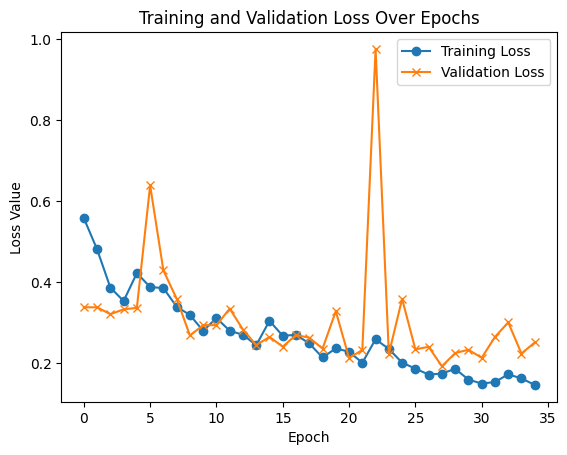

In [11]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the training loss values
ax.plot(train_loss, marker='o', label='Training Loss')

# Plot the validation loss values
ax.plot(validation_loss, marker='x', label='Validation Loss')

# Set the title and labels
ax.set_title('Training and Validation Loss Over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss Value')

# Add a legend
ax.legend()

# Show the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


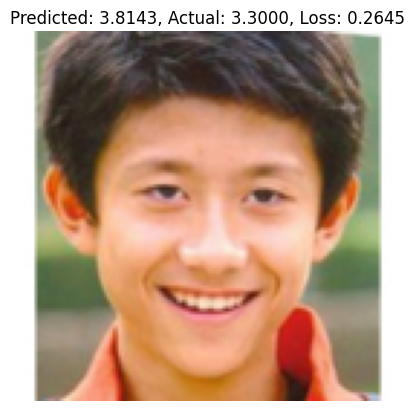

In [12]:
# Demo of the model on validation set.

index = 0
# Get the image and label
images, labels = next(iter(val_loader))
image = images[index]
label = labels[index]

image = image.unsqueeze(0)


# Move the image and the model to the same device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)
model = model.to(device)

with torch.no_grad():
    output = model(image).to(device)
    
# Assuming a regression task, use MSELoss
loss = criterion(output, label.unsqueeze(0).to(device))

# Display the image and prediction
image = image.squeeze().cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.title(f"Predicted: {output.item():.4f}, Actual: {label.item():.4f}, Loss: {loss.item():.4f}")
plt.axis('off')
plt.show()

In [23]:
# Load the best model
model = BeautyCNN()
model.load_state_dict(torch.load('beautycnn.weight', map_location=torch.device(device)))
model.eval()

BeautyCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Batch

In [25]:
device = 'cpu'

In [26]:
from torcheval.metrics import R2Score
all_preds = []
all_labels = []
val_loss = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).to(device)
        all_preds.extend(outputs.squeeze())
        all_labels.extend(labels)
        
        loss = criterion(outputs.squeeze(), labels)
        val_loss += loss.item() * images.size(0)

all_preds = torch.tensor(all_preds)
all_labels = torch.tensor(all_labels)
val_loss /= len(val_loader.dataset)
print(f'MSE validation Loss: {val_loss:.4f}')

## R Squared
r2score_metric = R2Score()
r2score_metric.update(all_preds, all_labels)
r_squared = r2score_metric.compute()
print(f'R Squared validation Loss: {r_squared:.4f}')

## MAE Loss
MAE = nn.L1Loss() 
mae_score = MAE(all_preds, all_labels) 

print("MAE validation loss: ", mae_score)

MSE validation Loss: 0.1924
R Squared validation Loss: 0.5889
MAE validation loss:  tensor(0.3412)
